In [1]:
import agama
import arepo
import h5py as h5
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import matplotlib as mpl

from scipy.ndimage import gaussian_filter

from numba import njit

agama.setUnits(mass=1E10, length=1, velocity=1)

'Length unit: 1 Kpc, velocity unit: 1 km/s, time unit: 977.793 Myr, mass unit: 1e+10 Msun, gravitational constant: 43009.2'

In [2]:
@njit
def my_mult(mass, vel):
    out = np.zeros((len(mass), 3))
    for i in range(len(mass)):
        out[i][0] = mass[i] * vel[i][0] 
        out[i][1] = mass[i] * vel[i][1]
        out[i][2] = mass[i] * vel[i][2]
    return out

In [3]:
sim_list = ['Nbody', 'phantom-vacuum-Sg20-Rc3.5']

basepath = '/n/holystore01/LABS/hernquist_lab/Users/abeane/starbar_runs/runs/'

def read_snap(idx, sim_idx, lvl='lvl3', parttype=[0], fields=['Coordinates', 'Masses', 'Velocities', 'ParticleIDs', 'Potential'],
              basepath = basepath):
    fname = basepath + sim_list[sim_idx] + '/' + lvl + '/output'
    return arepo.Snapshot(fname, idx, parttype=parttype, fields=fields, combineFiles=True)

def read_sfr(sim_idx, lvl='lvl3', basepath = basepath):
    fname = basepath + sim_list[sim_idx] + '/' + lvl + '/output/sfr.txt'
    return np.genfromtxt(fname)

def read_fourier(sim_idx, lvl='lvl3', basepath='/n/home01/abeane/starbar/plots/'):
    sim = sim_list[sim_idx]
    f = h5.File(basepath+'/fourier_component/data/fourier_'+sim+'-'+lvl+'.hdf5', mode='r')
    return f

In [4]:
sn = read_snap(300, 1, 'lvl2', parttype=None, fields=None)

In [5]:
base = '/n/home01/abeane/starbar/plots/bar_prop/data/'

bar_prop_N = h5.File(base + 'bar_prop_Nbody-lvl3.hdf5', mode='r')
bar_prop_S = h5.File(base + 'bar_prop_phantom-vacuum-Sg20-Rc3.5-lvl3.hdf5', mode='r')

In [6]:
sun_angle = 20. * (np.pi / 180.)
# bangle = bar_prop_S['bar_angle'][300] + sun_angle
bangle = 22. * (np.pi / 180.) + sun_angle

In [7]:
def rotate_pos(pos, ang):

    Rmat = np.array([[np.cos(ang), -np.sin(ang), 0.0],
                     [np.sin(ang),  np.cos(ang), 0.0],
                     [0.0,         0.0,          1.0]])
    
    pos = np.swapaxes(pos, 0, 1)
    pos = np.matmul(Rmat, pos)
    pos = np.swapaxes(pos, 0, 1)
    
    return pos

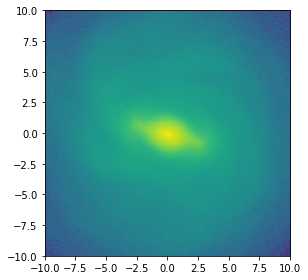

In [8]:
nres = 512

range_xy = [[-10, 10], [-10, 10]]
center = np.array([200., 200., 200.])

disk_pos = sn.part2.pos.value - center
disk_pos = rotate_pos(disk_pos, -bangle)

x = disk_pos[:,0]
y = disk_pos[:,1]
heatmap_xy, _, _ = np.histogram2d(x, y, bins=(nres, nres), range=range_xy)

extent = [range_xy[0][0], range_xy[0][1], range_xy[1][0], range_xy[1][1]]

fig, ax = plt.subplots(1, 1)

ax.imshow(heatmap_xy.T, extent=extent, origin='lower', norm=mpl.colors.LogNorm())
ax.set_aspect('equal')
fig.tight_layout()

plt.show()


In [9]:
import healpy as hp

In [10]:
sun_pos = np.array([-8.2, 0.0, 0.0])

In [11]:
gas_pos = sn.part0.pos.value - center
gas_pos = rotate_pos(gas_pos, -bangle)

drvec = gas_pos - sun_pos

r = np.linalg.norm(drvec, axis=1)
theta = np.arccos(drvec[:,2]/r)
phi = np.arctan2(drvec[:,1], drvec[:,0])


In [12]:
nside = 64

pix = hp.pixelfunc.ang2pix(nside, theta, phi)

In [13]:
npix = hp.pixelfunc.nside2npix(nside)
gas_plot = np.zeros(npix)
gas_plot[pix] += sn.part0.mass.value / r**2

In [14]:
gas_plot[gas_plot==0] = np.min(gas_plot)

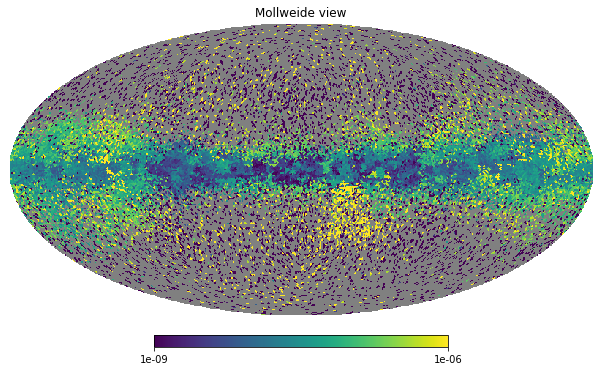

In [15]:
hp.mollview(gas_plot, norm='log', min=1E-09, max=1E-06)
plt.show()

In [19]:
rhat = my_mult(1./r, drvec)

v = sn.part0.vel.value

in_ball = r < 0.2
vdisk = sn.part2.vel.value
xdisk = sn.part2.pos.value
xdisk = xdisk - center
dr = xdisk - sun_pos
rdisk = np.linalg.norm(dr, axis=1)
vLSR = np.mean(vdisk[rdisk < 0.2], axis=0)

# v = v - vLSR

vr = rhat[:,0] * v[:,0] + rhat[:,1] * v[:,1] + rhat[:,2] * v[:,2]

In [20]:
vLSR

array([  -2.0876443 , -243.98615   ,   -0.38128683], dtype=float32)

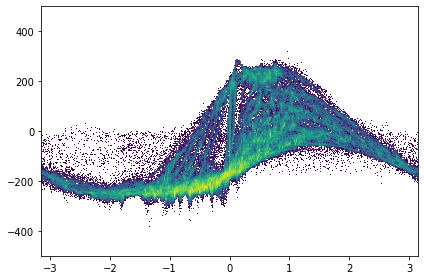

In [21]:
nres = 512

range_xy = [[-np.pi, np.pi], [-500, 500]]

x = -phi
y = vr
heatmap_xy, _, _ = np.histogram2d(x, y, bins=(nres, nres), range=range_xy)

extent = [range_xy[0][0], range_xy[0][1], range_xy[1][0], range_xy[1][1]]

fig, ax = plt.subplots(1, 1)

ax.imshow(heatmap_xy.T, extent=extent, origin='lower', norm=mpl.colors.LogNorm())
ax.set_aspect('auto')
fig.tight_layout()

plt.show()
